In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import ipywidgets as widgets
from ipywidgets import interact
import seaborn as sns

from utils.load_data import load_data, load_gt_data
from utils.preprocessing_v2 import Preprocessing, get_gt_diff_logs
from models.MLP import MLP
from models.LinearModels import OLS
from utils.downward_trend_removal import detrend_gts

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
TRAIN_PROPORTION = 0.9
MODE = "pct" # None | "pct" | "diff"
PERIOD = 4  # Year to year prediction
EPS = 1e-15
SEED = 42
data, all_gdps, all_gts = load_data()

In [3]:
preprocessor = Preprocessing(epsilon=EPS, gdp_diff_period=PERIOD, all_GDPs=all_gdps, all_GTs=all_gts)
X_train, y_train, X_valid, y_valid, _ = preprocessor.preprocess_data(train_pct=TRAIN_PROPORTION, 
                                                                  mode="diff",
                                                                  take_log_diff_gdp=True, 
                                                                  gt_trend_removal=False, 
                                                                  keep_pca_components=180, 
                                                                  noisy_data_stds=[0.001, 0.005, 0.01], 
                                                                  add_encoded_month=False, 
                                                                  gt_data_transformations=[get_gt_diff_logs])


X_train shape : (1780, 180)
X_valid shape : (53, 180)
y_train shape : (1780,)
y_valid shape : (53,)
X_high_freq shape : (1547, 180)


In [ ]:
models = {
    'MLP': MLP(seed=SEED, n_models=5),
    'OLS': OLS(),
}

y_pred_train = {}
y_pred_valid = {}
for model in models:
    # Fit and predict on training and validation data
    print(f"Training {model}")

    if 'KF' in model:
        models[model].fit(X_train, y_train, countries=preprocessor.country_train)
    else: 
        models[model].fit(X_train, y_train)


    y_pred_train[model] = models[model].predict(X_train, countries=preprocessor.country_train) if 'KF' in model else models[model].predict(X_train)
    y_pred_valid[model] = models[model].predict(X_valid, countries=preprocessor.country_valid) if 'KF' in model else models[model].predict(X_valid)

Training MLP
Training KF on MLP
Training OLS


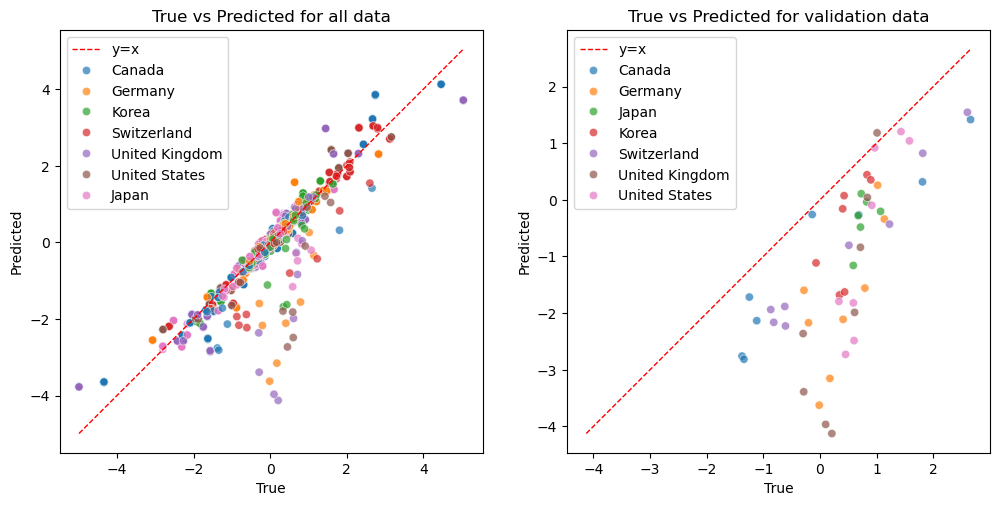

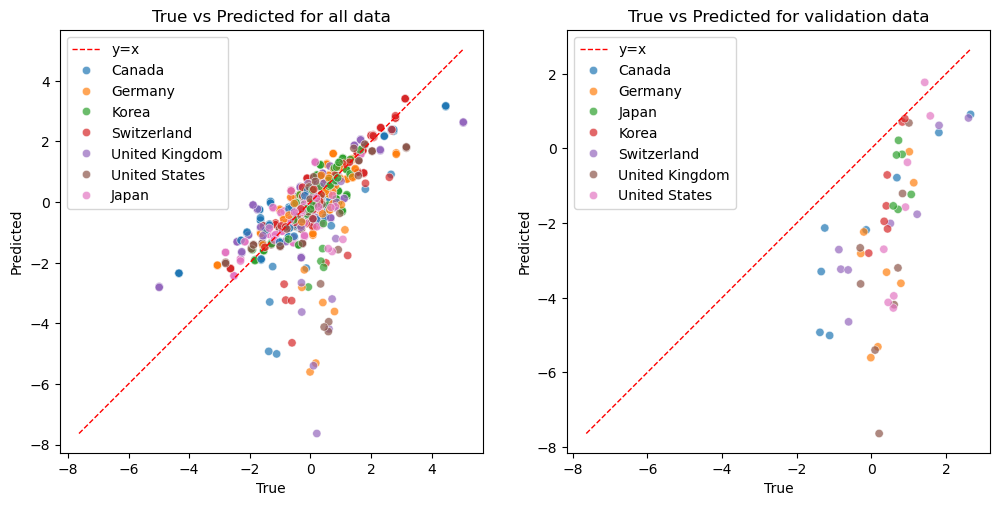

In [5]:
# Associate the result by country
y_pred_valid_country = pd.DataFrame(dict({'date': preprocessor.dates_valid, 'country': preprocessor.country_valid, 'True GDP': y_valid}, **y_pred_valid))
y_pred_train_country = pd.DataFrame(dict({'date': preprocessor.dates_train, 'country': preprocessor.country_train, 'True GDP': y_train}, **y_pred_train))

# Put together the train and the validation set
predictions = pd.concat([y_pred_train_country, y_pred_valid_country])

# Melting the dataframe for better plotting
predictions_melted = predictions.melt(
    id_vars=["date", "country"], value_vars=["True GDP"] + [model for model in models],
    var_name="Type", value_name="Value"
)

def plot_predictions_against_true(true_key="True GDP", pred_key="y_pred"):
    plt.figure(figsize=(12, 6))

    ax = plt.subplot(1, 2, 1)
    ax.set_box_aspect(1)

    line_min = np.min([np.min(predictions[true_key]), np.min(predictions[pred_key])])
    line_max = np.max([np.max(predictions[true_key]), np.max(predictions[pred_key])])
    plt.plot([line_min, line_max], [line_min, line_max], color='red', linewidth=1, linestyle='--', label='y=x')
    sns.scatterplot(x=true_key, y=pred_key, data=predictions, hue='country', alpha=0.7)
    plt.title('True vs Predicted for all data')
    plt.xlabel('True')
    plt.ylabel('Predicted')
    plt.legend()

    ax = plt.subplot(1, 2, 2)
    ax.set_box_aspect(1)

    line_min = np.min([np.min(y_pred_valid_country[true_key]), np.min(y_pred_valid_country[pred_key])])
    line_max = np.max([np.max(y_pred_valid_country[true_key]), np.max(y_pred_valid_country[pred_key])])
    plt.plot([line_min, line_max], [line_min, line_max], color='red', linewidth=1, linestyle='--', label='y=x')
    sns.scatterplot(x=true_key, y=pred_key, data=y_pred_valid_country, hue='country', alpha=0.7)
    plt.title('True vs Predicted for validation data')
    plt.xlabel('True')
    plt.ylabel('Predicted')
    plt.legend()

    plt.show()

plot_predictions_against_true(pred_key="KF on MLP")
plot_predictions_against_true(pred_key="OLS")

In [6]:
# Function to plot data with confidence intervals for the selected country
def plot_by_country(selected_country):
    filtered_data = predictions_melted[predictions_melted["country"] == selected_country]
    cutoff_date = filtered_data[filtered_data['Type'] == 'True GDP']['date'].quantile(TRAIN_PROPORTION)

    plt.figure(figsize=(12, 6))

    # Plot predictions and true values
    sns.lineplot(
        data=filtered_data,
        x="date", y="Value", hue="Type", style="Type", markers=True, dashes=False
    )

    # Add a vertical line to indicate where validation starts
    plt.axvline(x=cutoff_date, color='red', linestyle='--', label=f'Validation Start ({(TRAIN_PROPORTION)*100:.0f}%)')

    # Enhancing the plot
    plt.title(f"Prediction vs True Values for {selected_country}")
    plt.xlabel("Date")
    plt.ylabel("Values")
    plt.legend(title="Legend")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Create a dropdown widget for selecting the country
countries = predictions["country"].unique()
dropdown = widgets.Dropdown(
    options=countries,
    value=countries[0],
    description='Country:'
)

# Use the interact function to link the dropdown with the updated plot function
interact(plot_by_country, selected_country=dropdown)

# Calculate Mean Squared Error
for model in models:
    print(f"{model} : Training  ME: {mean_squared_error(y_train, y_pred_train[model]):.4f}", end="")
    print(f", Validation MSE: {mean_squared_error(y_valid, y_pred_valid[model]):.4f}")
    print()

interactive(children=(Dropdown(description='Country:', options=('Canada', 'Germany', 'Korea', 'Switzerland', '…

MLP : Training  ME: 0.0001, Validation MSE: 3.0060

KF on MLP : Training  ME: 0.0533, Validation MSE: 3.3392

OLS : Training  ME: 0.2733, Validation MSE: 9.1054

